#Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#Image Processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values to be between 0 and 1
    shear_range=0.2,  # Shear intensity
    zoom_range=0.2,   # Zoom range
    horizontal_flip=True  # Randomly flip images horizontally
)

In [ ]:
# Defining image and batch size
img_size = (128, 128)
batch_size = 32

In [ ]:
# Implementing the datagen class instance created earlier on our images
data_generator = datagen.flow_from_directory('/content/drive/MyDrive/4th',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'  # Set to 'categorical' for multiclass classification
)

Found 2080 images belonging to 3 classes.


In [ ]:
#Using the concurrent.futures module to launch parallel tasks of adding images and labels to a list
import concurrent.futures

# Defining a function to process a batch
def process_batch(batch):
    batch_images, batch_labels = data_generator.next()
    return batch_images, batch_labels

num_workers = 8

images = []
labels = []

# Using ThreadPoolExecutor for parallel processing
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Submitting tasks for each batch
    futures = [executor.submit(process_batch, None) for _ in range(len(data_generator))]

    # Retrieving results as they become available
    for future in concurrent.futures.as_completed(futures):
        batch_images, batch_labels = future.result()
        images.extend(batch_images)
        labels.extend(batch_labels)

In [ ]:
labels[0]

array([0., 0., 1.], dtype=float32)

In [ ]:
print(f'Number of images: {len(images)} \nNumber of labels: {len(labels)}')

Number of images: 2080 
Number of labels: 2080


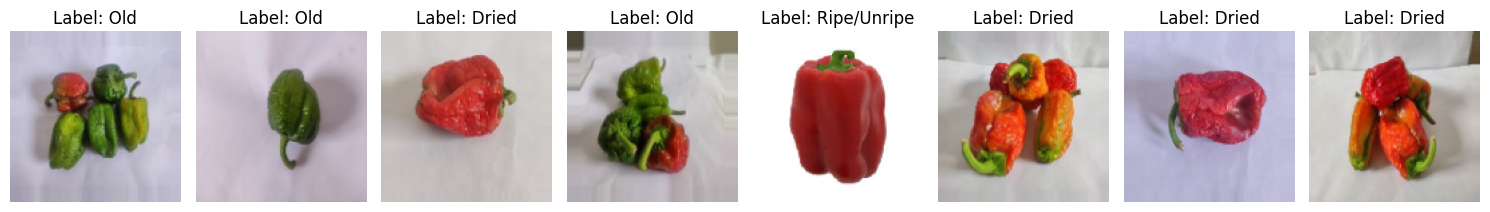

In [ ]:
# Randomly plotting our images
import random

# Sample size for plotting
sample_size = 8

# Randomly selecting a few samples from your dataset
selected_samples = random.sample(range(len(images)), sample_size)

# Creating a subplot with rows and columns
rows = 1
cols = sample_size

# Seting up our subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 8))
arr1 = np.array([1,0,0])
arr2=np.array([0,1,0])
arr3=np.array([0,0,1])

# Ploting selected images in the subplot
for i, ax in zip(selected_samples, axes):
    image = images[i]
    label = labels[i]
    # Assuming images are NumPy arrays
    ax.imshow(image)
    if np.array_equal(label, arr1):
      ax.set_title(f"Label: Dried")
    elif np.array_equal(label, arr2):
      ax.set_title(f"Label: Old")
    else:
      ax.set_title(f"Label: Ripe/Unripe")
    ax.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()

In [ ]:
labels[0]

array([0., 0., 1.], dtype=float32)

#Splitting Training Sets and Validation Sets

In [ ]:
# Dividing dataset to train test and validaiton sets
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Saving images to variable X and corresponding labels to variable y
X = images
y = labels

# Shuffling the data
X, y_encoded = shuffle(X, y, random_state=42)

# Split the data into training, testing, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5)

In [ ]:
# Converting our data into numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Converting test datasets to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

#Training Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

# Creating the model
model = Sequential()

# First convolution layer
model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second convolution layer
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Third convolution layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Fourth convolution layer
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flatten layer
model.add(Flatten())

# Dense layers
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3))
model.add(Activation('softmax'))

print(model.summary())

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_100 (Conv2D)         (None, 126, 126, 32)      896       
                                                                 
 activation_94 (Activation)  (None, 126, 126, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_101 (Conv2D)         (None, 61, 61, 32)        9248      
                                                                 
 activation_95 (Activation)  (None, 61, 61, 32)        0         
                                                      

In [ ]:
# Defining Early stopping and Model check point
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

ES = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
MC = ModelCheckpoint('best.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
# Fitting the Training Data
history = model.fit_generator(
    Train_generator,
    epochs=epoch,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples//batch_size,
    steps_per_epoch=nb_train_samples//batch_size,
    callbacks=[ES,MC])

NameError: name 'Train_generator' is not defined

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions

In [ ]:
# Loading pretrained VGG16 model with weights trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
y_train.shape

(1664, 3)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers, models

for layer in base_model.layers:
    layer.trainable = False

# Create your own model on top of VGG16
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())  # Make sure Flatten layer is here
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(512, activation='relu'))

model.add(layers.Dense(3, activation='softmax'))

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Training the vgg16 pretrained model with my dataset
vgg_model = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))

Epoch 1/30
52/52 [==============================] - 11s 82ms/step - loss: 0.5088 - accuracy: 0.8107 - val_loss: 0.1669 - val_accuracy: 0.9279
Epoch 2/30
52/52 [==============================] - 2s 45ms/step - loss: 0.1439 - accuracy: 0.9483 - val_loss: 0.1036 - val_accuracy: 0.9423
Epoch 3/30
52/52 [==============================] - 2s 45ms/step - loss: 0.0613 - accuracy: 0.9766 - val_loss: 0.0623 - val_accuracy: 0.9760
Epoch 4/30
52/52 [==============================] - 2s 46ms/step - loss: 0.0333 - accuracy: 0.9886 - val_loss: 0.0830 - val_accuracy: 0.9663
Epoch 5/30
52/52 [==============================] - 2s 46ms/step - loss: 0.0361 - accuracy: 0.9880 - val_loss: 0.0274 - val_accuracy: 0.9952
Epoch 6/30
52/52 [==============================] - 2s 45ms/step - loss: 0.0116 - accuracy: 0.9964 - val_loss: 0.0758 - val_accuracy: 0.9856
Epoch 7/30
52/52 [==============================] - 2s 45ms/step - loss: 0.0486 - accuracy: 0.9814 - val_loss: 0.0945 - val_accuracy: 0.9760
Epoch 8/30
5

#Training Validation

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 16945219 (64.64 MB)
Trainable params: 2230531 (8.51 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


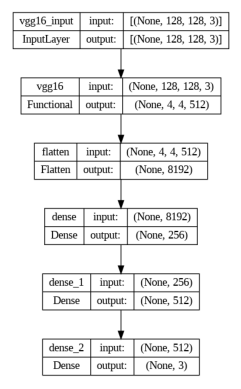

In [ ]:
from tensorflow.keras.utils import plot_model

# Displaying the model architecture summary
vgg_model.model.summary()

# Saving the model architecture plot to a file
plot_model(vgg_model.model, to_file='vgg_model_plot.png', show_shapes=True, show_layer_names=True)

# Displaying the model architecture plot within the script
img = plt.imread('vgg_model_plot.png')
plt.imshow(img)
plt.axis('off')
plt.show()


In [ ]:
eval_result = model.evaluate(X_test, y_test)

# The evaluate method returns a list containing the loss and metrics values
# Assuming accuracy is one of the metrics, you can access it as follows:
accuracy = eval_result[1]

print(f'Test Accuracy: {accuracy * 100:.2f}%')

7/7 [==============================] - 0s 50ms/step - loss: 0.2392 - accuracy: 0.9663
Test Accuracy: 96.63%


In [ ]:
y_test.shape

(208, 3)

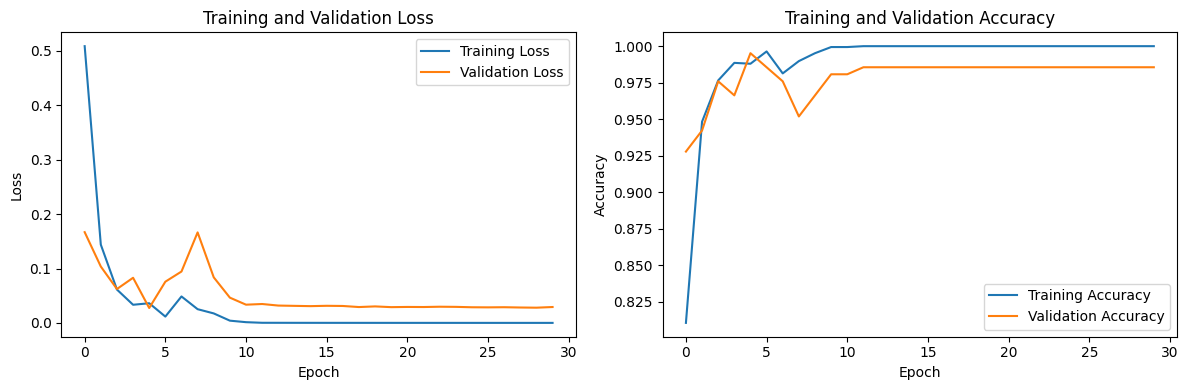

In [ ]:
# Model Performance during training

# Training and validation loss plots
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(vgg_model.history['loss'], label='Training Loss')
plt.plot(vgg_model.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Training and validation accuracy plots
plt.subplot(1, 2, 2)
plt.plot(vgg_model.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_model.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Assuming X_test and y_test are your test set and labels
# X_test = ...
# y_test = ...

# Make predictions
batch_size = 4  # or any other value
y_pred_batches = []

for i in range(0, len(X_test), batch_size):
    batch_predictions = model.predict(X_test[i:i+batch_size])
    y_pred_batches.append(batch_predictions)

y_pred = np.concatenate(y_pred_batches, axis=0)
# Convert predictions to binary indicator matrix
threshold = 0.5  # You can adjust the threshold based on your needs
predicted_classes = (y_pred > threshold).astype(int)

# Ensure y_test is in the correct format for multilabel classification
# y_test = [[1, 0, 1], [0, 1, 0], [1, 1, 1], ...]

# Compute accuracy
accuracy = accuracy_score(y_test, predicted_classes)
print(f"Accuracy: {accuracy * 100:.2f}%")

1/1 [==============================] - 0s 19ms/step
Accuracy: 96.63%


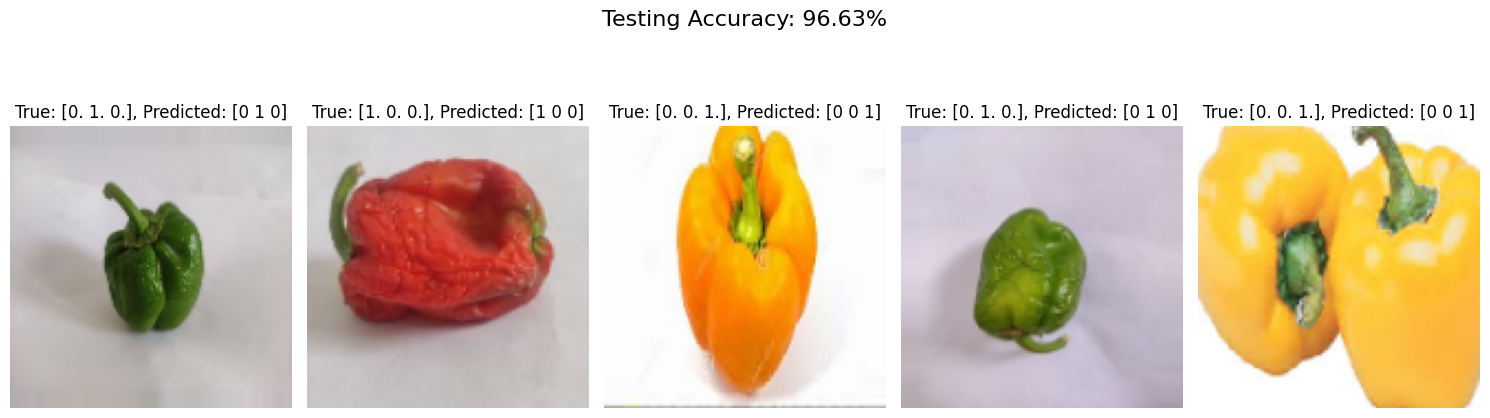

In [ ]:
# We will need to convert the probability values into binary predictions. First we set a threshold value to divide the probability values into corresponding classes
threshold = 0.5
binary_predictions = (y_pred > threshold).astype(int)

# Calculating testing accuracy
test_accuracy = np.sum(binary_predictions.squeeze() == y_test) / len(y_test)

# Sample size for plotting
test_size = 5

# Randomly selecting a few samples from the testing set
test_samples = np.random.choice(range(len(X_test)), test_size, replace=False)

# Now we create a subplot with rows and columns
rows = 1
cols = test_size

# Setting up the subplot
fig, axes = plt.subplots(rows, cols, figsize=(15, 5))

# Plotting the selected images with corresponding predictions of our model
for i, ax in zip(test_samples, axes):
    image = X_test[i]
    true_label = y_test[i]
    predicted_label = binary_predictions[i]
    ax.imshow(image)
    ax.set_title(f"True: {true_label}, Predicted: {predicted_label}")
    ax.axis('off')  # Turning off axis labels as it overlaps with our class labels on the plot

#Display testing accuracy on the plot
fig.suptitle(f"Testing Accuracy: {accuracy * 100:.2f}%", fontsize=16)

#Adjusting layout to prevent clipping
plt.tight_layout(rect=[0, 0.1, 1, 0.9])  # Adjust the top margin to make space for the title
plt.show()

#Save Model

In [ ]:
model.save("../1-26-24bellpepperVGG16.h5")

#Test Model with new images

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/1-26-24bellpepperVGG16.h5')

# Load and preprocess new images
image_paths = ['/content/drive/MyDrive/Model Testing Images/6.jpg', '/content/drive/MyDrive/Model Testing Images/bad bp.jpg', '/content/drive/MyDrive/Model Testing Images/bad bp1.jpg']
new_images = []

for image_path in image_paths:
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)
    new_images.append(img_array)

new_images = np.array(new_images)

# Make predictions
predictions = model.predict(new_images)

# Convert predictions to binary indicator matrix
threshold = 0.5  # You can adjust the threshold based on your needs
predicted_classes = (predictions > threshold).astype(int)

# Visualize the results
for i in range(len(image_paths)):
    img_path = image_paths[i]
    true_label = "unknown"  # You might know the true labels if available
    predicted_label = predicted_classes[i]

    # Plotting the selected image with corresponding prediction
    plt.imshow(image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE)))
    plt.title(f"True: {true_label}, Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Model Testing Images/6.jpg'